# Capstone Project

## Image classifier for the Street View House Numbers dataset

The task is to develop MLP and CNN models in order to verify their performance as well as generalization on the test set. The assumption is that CNN will have less parameters requiring a bit longer training time, but resulting in better generalization on unseen set. 

Both models' types will use the same optimizer and loss, as well as metrics.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.io import loadmat
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.initializers import he_uniform, ones
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

### Load and inspect the sets

In [3]:
train_data = loadmat('./project_svhn_classification/assets/train_32x32.mat')
test_data = loadmat('./project_svhn_classification/assets/test_32x32.mat')

In [4]:
X_train, y_train = train_data['X'], train_data['y']
X_test, y_test = test_data['X'], test_data['y']

print('X training shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('\nUniq labels in the train set: ', np.unique(y_train))
print('Uniq labels in the test set: ', np.unique(y_test))

X training shape:  (32, 32, 3, 73257)
y train shape:  (73257, 1)

Uniq labels in the train set:  [ 1  2  3  4  5  6  7  8  9 10]
Uniq labels in the test set:  [ 1  2  3  4  5  6  7  8  9 10]


#### Replace the label "10" with "0"

In [5]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

print('\nUniq labels in the train set: ', np.unique(y_train))
print('Uniq labels in the test set: ', np.unique(y_test))


Uniq labels in the train set:  [0 1 2 3 4 5 6 7 8 9]
Uniq labels in the test set:  [0 1 2 3 4 5 6 7 8 9]


#### Move the samples axis as first

In [10]:
X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)

print('X training shape: ', X_train.shape)
print('X testing shape: ', X_test.shape)

X training shape:  (73257, 32, 32, 3)
X testing shape:  (26032, 32, 32, 3)


#### Display images from the "train" set

In [21]:
def display_sample_images(data_set, labels_setb):
    fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(20, 10))

    for i in range(10):
        idx = np.random.choice(range(data_set.shape[0]))
        ax[i].set_axis_off()
        ax[i].imshow(data_set[idx], interpolation='nearest')
        ax[i].set_title(f'Label: {labels_set[idx][0]}')

    plt.subplots_adjust(wspace=1)

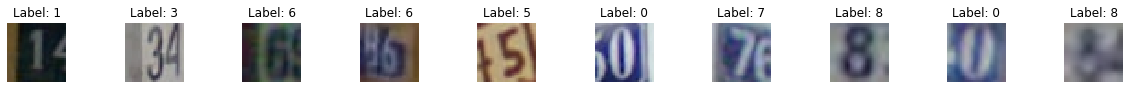

In [22]:
display_sample_images(X_train, y_train)

#### Display images from the "test" set

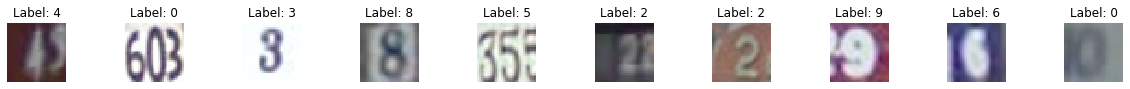

In [24]:
display_sample_images(X_test, y_test)

#### Normalize data

In [25]:
X_train_inputs = np.mean(X_train, axis=3, keepdims=True) / 255.
X_test_inputs = np.mean(X_test, axis=3, keepdims=True) / 255.

print('X training inputs shape: ', X_train_inputs.shape)
print('X testing inputs shape: ', X_test_inputs.shape)

X training inputs shape:  (73257, 32, 32, 1)
X testing inputs shape:  (26032, 32, 32, 1)


#### Display normalized images - train set

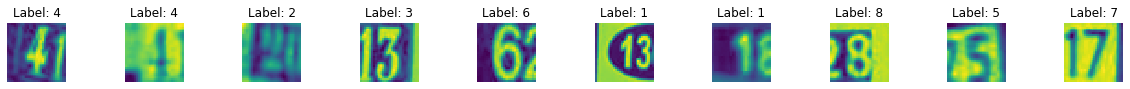

In [28]:
display_sample_images(X_train_inputs, y_train)

### The MLP model

In [31]:
def build_mlp_model(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape, name='flatten'),
        Dense(units=128,
              activation=relu,
              kernel_initializer=he_uniform(),
              bias_initializer=he_uniform(),
              name='dense_1'),
        Dense(units=64,
              activation=relu,
              kernel_initializer=he_uniform(),
              bias_initializer=he_uniform(),
              name='dense_2'),
        Dense(units=32,
              activation=relu,
              kernel_initializer=he_uniform(),
              bias_initializer=he_uniform(),
              name='dense_3'),
        Dense(units=10,
              activation=softmax,
              kernel_initializer=he_uniform(),
              bias_initializer=he_uniform(),
              name='dense_output')
    ])
    model.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy'])
    return model

In [61]:
mlp_model = build_mlp_model(input_shape=X_train_inputs[0].shape)
mlp_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_output (Dense)         (None, 10)                330       
Total params: 141,866
Trainable params: 141,866
Non-trainable params: 0
_________________________________________________________________


#### Learning callbacks

In [33]:
best_mlp_model_cb = ModelCheckpoint(filepath='most_accurate_model/model_{epoch}', 
                               monitor='val_accuracy',
                               save_best_only=True,
                               save_weights_only=True,
                               mode='max',
                               verbose=1)

early_stopping_cb = EarlyStopping(monitor='val_loss',
                                  min_delta=1e-2, 
                                  patience=4, 
                                  verbose=1)

lr_reduction_cb = ReduceLROnPlateau(monitor='val_loss',
                                    factor=1e-4,
                                    patience=2,
                                    mode='min',
                                    verbose=1)

#### Train MLP model

In [62]:
mlp_history = mlp_model.fit(x=X_train_inputs,
                            y=y_train,
                            epochs=50,
                            batch_size=64, 
                            validation_data=(X_test_inputs, y_test),
                            callbacks=[
                                best_mlp_model_cb,
                                early_stopping_cb,
                                lr_reduction_cb,
                            ])

Epoch 1/50
1145/1145 [==============================] - 2s 2ms/step - loss: 2.2490 - accuracy: 0.1855 - val_loss: 1.9035 - val_accuracy: 0.3633

Epoch 00001: val_accuracy did not improve from 0.74977
Epoch 2/50
1145/1145 [==============================] - 2s 2ms/step - loss: 1.6686 - accuracy: 0.4295 - val_loss: 1.4014 - val_accuracy: 0.5515

Epoch 00002: val_accuracy did not improve from 0.74977
Epoch 3/50
1145/1145 [==============================] - 2s 2ms/step - loss: 1.3076 - accuracy: 0.5754 - val_loss: 1.3510 - val_accuracy: 0.5759

Epoch 00003: val_accuracy did not improve from 0.74977
Epoch 4/50
1145/1145 [==============================] - 2s 2ms/step - loss: 1.2059 - accuracy: 0.6158 - val_loss: 1.2785 - val_accuracy: 0.6007

Epoch 00004: val_accuracy did not improve from 0.74977
Epoch 5/50
1145/1145 [==============================] - 2s 2ms/step - loss: 1.1502 - accuracy: 0.6370 - val_loss: 1.2570 - val_accuracy: 0.6099

Epoch 00005: val_accuracy did not improve from 0.74977


In [36]:
def evaluate_model(model, name, set_inputs, labels):
    test_loss, test_accuracy = model.evaluate(x=set_inputs, y=labels, verbose=0)
    print(f'Evaluating model {name}')
    print(f'* Test accuracy: {np.round(test_accuracy, 3)}')
    print(f'* Test loss: {np.round(test_loss, 3)}')

In [63]:
evaluate_model(mlp_model, name='MLP', set_inputs=X_test_inputs, labels=y_test)

Evaluating model MLP
* Test accuracy: 0.675
* Test loss: 1.076


#### MLP model's performance: accuracy and sparse categorical crossentropy loss over epochs

In [59]:
def plot_history_performance(history):
    fig = plt.figure(figsize=(12, 5))
    fig.add_subplot(121)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    
    fig.add_subplot(122)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')

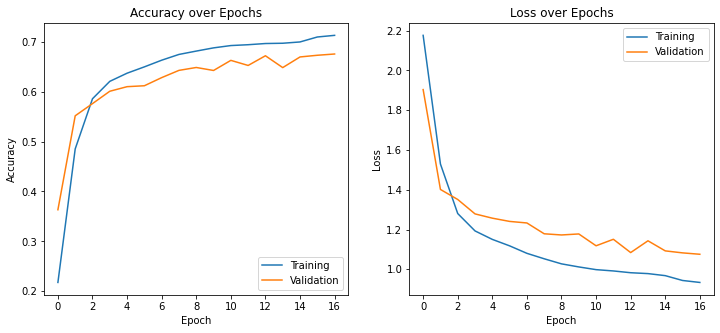

In [64]:
plot_history_performance(mlp_history.history)

### The CNN model

In [44]:
def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(filters=16,
               kernel_size=(3, 3),
               input_shape=input_shape,
               padding='same',
               activation=relu,
               kernel_initializer=he_uniform(),
               kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3),
               bias_initializer=he_uniform(),
               bias_regularizer=l1_l2(l1=1e-3, l2=1e-3),
               name='conv2d_1'),
        Conv2D(filters=8,
               kernel_size=(3, 3),
               padding='same',
               activation=relu,
               kernel_initializer=he_uniform(),
               kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3),
               bias_initializer=he_uniform(),
               bias_regularizer=l1_l2(l1=1e-3, l2=1e-3),
               name='conv2d_2'),
        MaxPooling2D(pool_size=(3, 3), name='max_pooling_2d_1'),
        BatchNormalization(name='batch_normalization_1'),
        Dropout(rate=0.3, name='dropout_1'),
        Conv2D(filters=8,
               kernel_size=(3, 3),
               padding='same',
               activation=relu,
               kernel_initializer=he_uniform(),
               kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3),
               bias_initializer=he_uniform(),
               bias_regularizer=l1_l2(l1=1e-3, l2=1e-3),
               name='conv2d_3'),
        MaxPooling2D(pool_size=(3, 3), name='max_pooling_2d_2'),
        Flatten(name='flatten'),
        Dense(units=32,
              activation=relu,
              kernel_initializer=he_uniform(),
              kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3),
              bias_initializer=he_uniform(),
              bias_regularizer=l1_l2(l1=1e-3, l2=1e-3),
              name='dense_1'),
        Dropout(0.3, name='dropout_2'),
        Dense(units=16,
              activation=relu,
              kernel_initializer=he_uniform(),
              bias_initializer=he_uniform(),
              kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3),
              name='dense_2'),
        Dense(units=10,
              activation=softmax,
              kernel_initializer=he_uniform(),
              kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3),
              bias_initializer=he_uniform(),
              bias_regularizer=l1_l2(l1=1e-3, l2=1e-3),
              name='dense_output')
    ])
    model.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy'])
    return model

In [45]:
cnn_model = build_cnn_model(input_shape=X_train_inputs[0].shape)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling_2d_1 (MaxPooling (None, 10, 10, 8)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 8)         32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 8)         584       
_________________________________________________________________
max_pooling_2d_2 (MaxPooling (None, 3, 3, 8)          

In [46]:
best_cnn_model_cb = ModelCheckpoint(filepath='most_accurate_cnn_model/model_{epoch}', 
                                    monitor='val_accuracy',
                                    save_best_only=True,
                                    save_weights_only=True,
                                    mode='max',
                                    verbose=1)

In [49]:
cnn_history = cnn_model.fit(x=X_train_inputs,
                            y=y_train,
                            epochs=50,
                            batch_size=64, 
                            validation_data=(X_test_inputs, y_test),
                            callbacks=[
                                best_cnn_model_cb,
                                early_stopping_cb,
                                lr_reduction_cb,
                            ])

Epoch 1/50
1145/1145 [==============================] - 32s 27ms/step - loss: 2.6862 - accuracy: 0.1910 - val_loss: 2.2098 - val_accuracy: 0.2995

Epoch 00001: val_accuracy did not improve from 0.75192
Epoch 2/50
1145/1145 [==============================] - 32s 28ms/step - loss: 1.9141 - accuracy: 0.4096 - val_loss: 1.5982 - val_accuracy: 0.5423

Epoch 00002: val_accuracy did not improve from 0.75192
Epoch 3/50
1145/1145 [==============================] - 32s 28ms/step - loss: 1.6568 - accuracy: 0.5145 - val_loss: 1.4570 - val_accuracy: 0.6044

Epoch 00003: val_accuracy did not improve from 0.75192
Epoch 4/50
1145/1145 [==============================] - 32s 28ms/step - loss: 1.4784 - accuracy: 0.5929 - val_loss: 1.2287 - val_accuracy: 0.6999

Epoch 00004: val_accuracy did not improve from 0.75192
Epoch 5/50
1145/1145 [==============================] - 33s 29ms/step - loss: 1.3742 - accuracy: 0.6366 - val_loss: 1.1378 - val_accuracy: 0.7372

Epoch 00005: val_accuracy did not improve fro

In [50]:
evaluate_model(cnn_model, name='CNN', set_inputs=X_test_inputs, labels=y_test)

Evaluating model CNN
* Test accuracy: 0.814
* Test loss: 0.908


#### MLP model's performance: accuracy and sparse categorical crossentropy loss over epochs

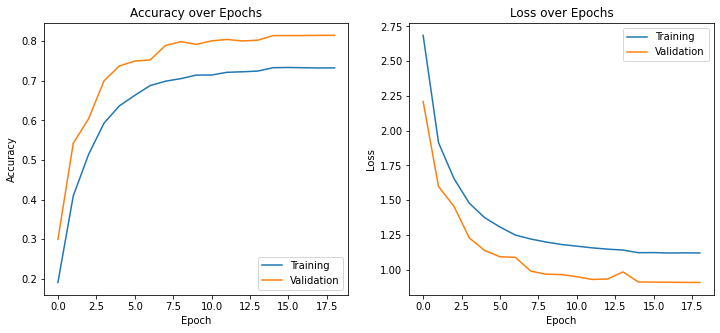

In [65]:
plot_history_performance(cnn_history.history)

### Load best models

In [55]:
best_mlp_model = build_mlp_model(input_shape=X_train_inputs[0].shape)
best_mlp_model.load_weights(tf.train.latest_checkpoint('most_accurate_model'))
evaluate_model(best_mlp_model, name='MLP', set_inputs=X_test_inputs, labels=y_test)

Evaluating model MLP
* Test accuracy: 0.75
* Test loss: 0.857


In [56]:
best_cnn_model = build_cnn_model(input_shape=X_train_inputs[0].shape)
best_cnn_model.load_weights(tf.train.latest_checkpoint('most_accurate_cnn_model'))
evaluate_model(best_cnn_model, name='CNN', set_inputs=X_test_inputs, labels=y_test)

Evaluating model CNN
* Test accuracy: 0.814
* Test loss: 0.908


#### Compare predictions using the test set

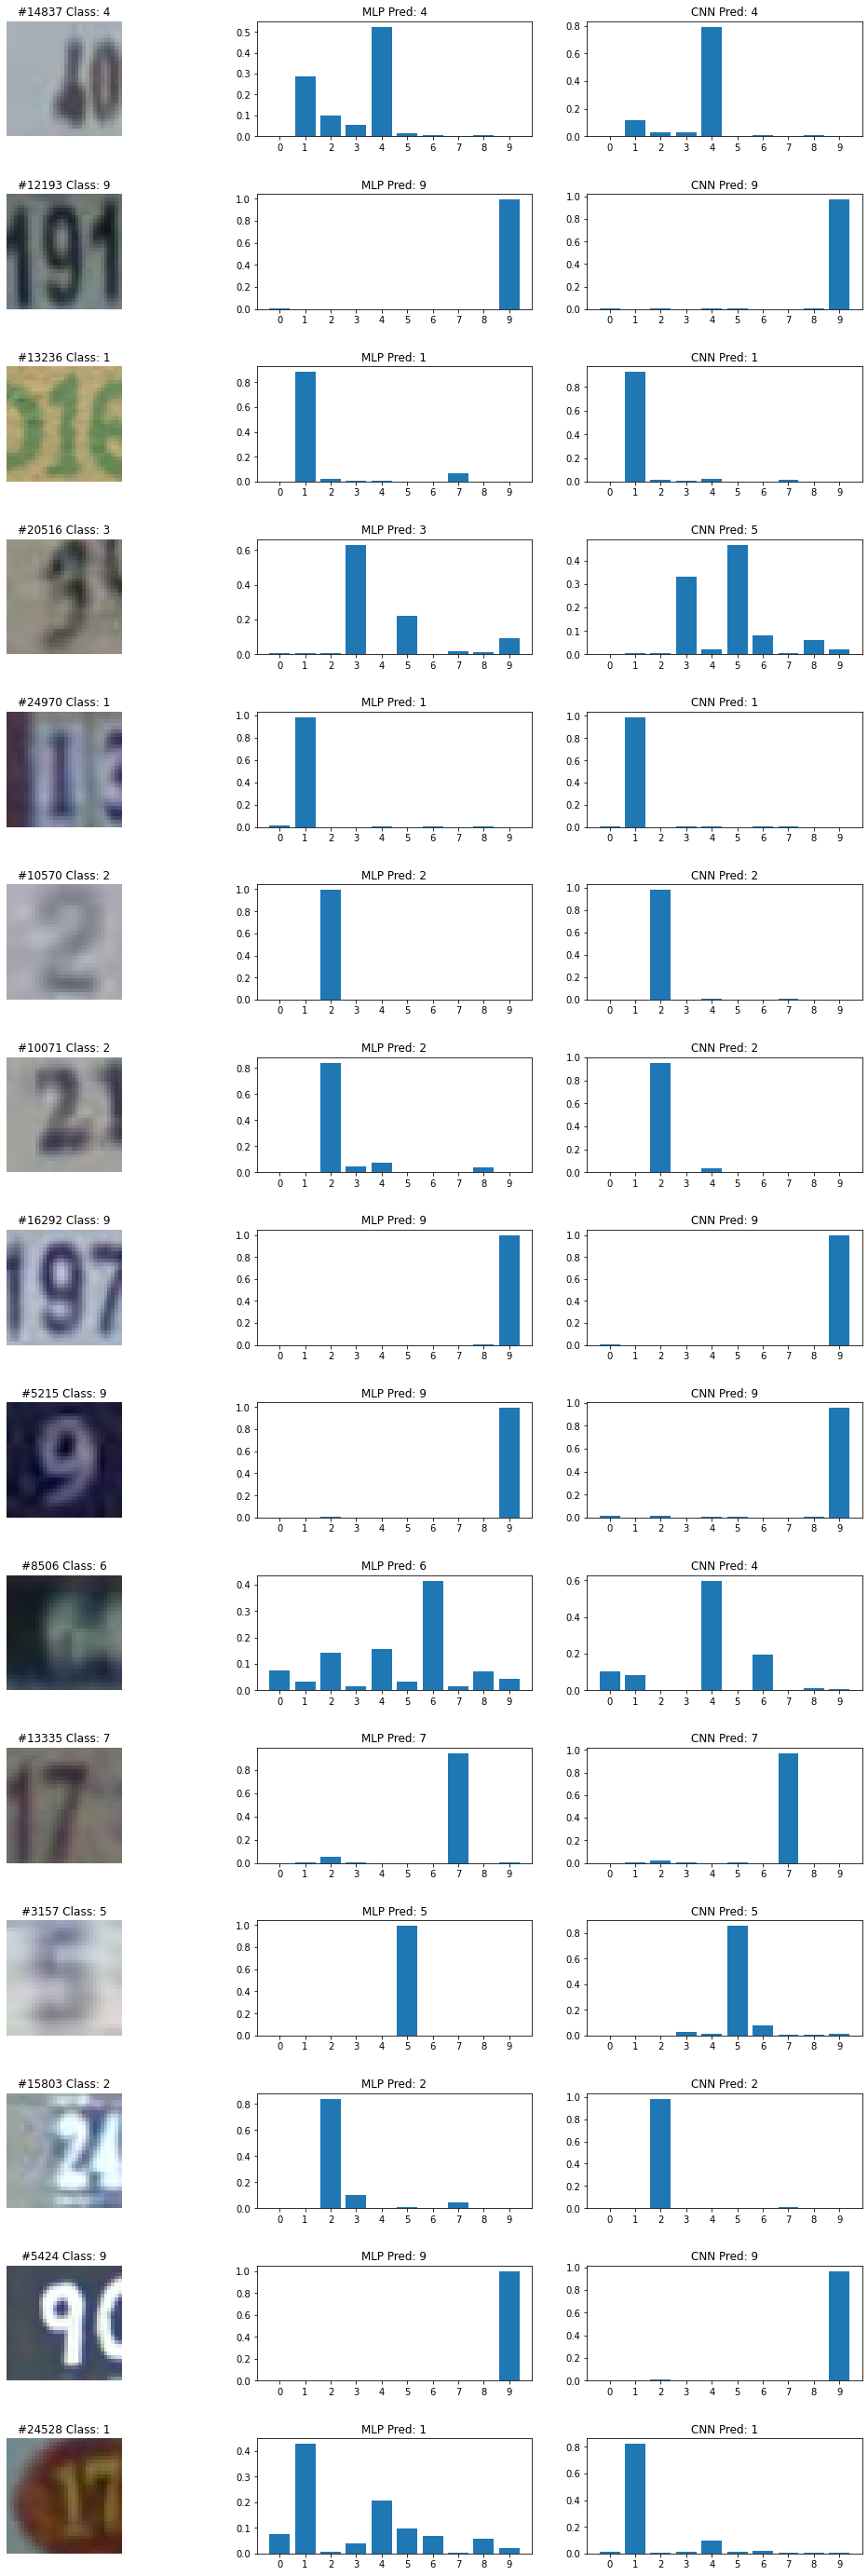

In [75]:
fig, ax = plt.subplots(nrows=15, ncols=3, figsize=(18, 50))

x_values = list(range(10))

for i in range(15):
    idx = np.random.choice(range(X_test_inputs.shape[0]))
    ax[i, 0].set_axis_off()
    ax[i, 0].imshow(X_test[idx], interpolation='nearest')
    ax[i, 0].set_title(f'#{idx} Class: {y_test[idx][0]}')
    
    img_input = X_test_inputs[idx][np.newaxis, ...]
    
    mlp_predictions = best_mlp_model.predict(img_input)
    mlp_prediction = np.argmax(mlp_predictions)
    ax[i, 1].set_title(f'MLP Pred: {mlp_prediction}')
    ax[i, 1].bar(x=x_values, height=mlp_predictions[0], tick_label=x_values)
    
    cnn_predictions = best_cnn_model.predict(img_input)
    cnn_prediction = np.argmax(cnn_predictions)
    ax[i, 2].set_title(f'CNN Pred: {cnn_prediction}')
    ax[i, 2].bar(x=x_values, height=cnn_predictions[0], tick_label=x_values)
    
plt.subplots_adjust(hspace=.5)